
# Assignment 2: Transformer Summarizer

Welcome to the second assignment of course 4. In this assignment you will explore summarization using the transformer model. Yes, you will implement the transformer decoder from scratch, but we will slowly walk you through it. There are many hints in this notebook so feel free to use them as needed. 

< src = "images/transformerNews.png">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>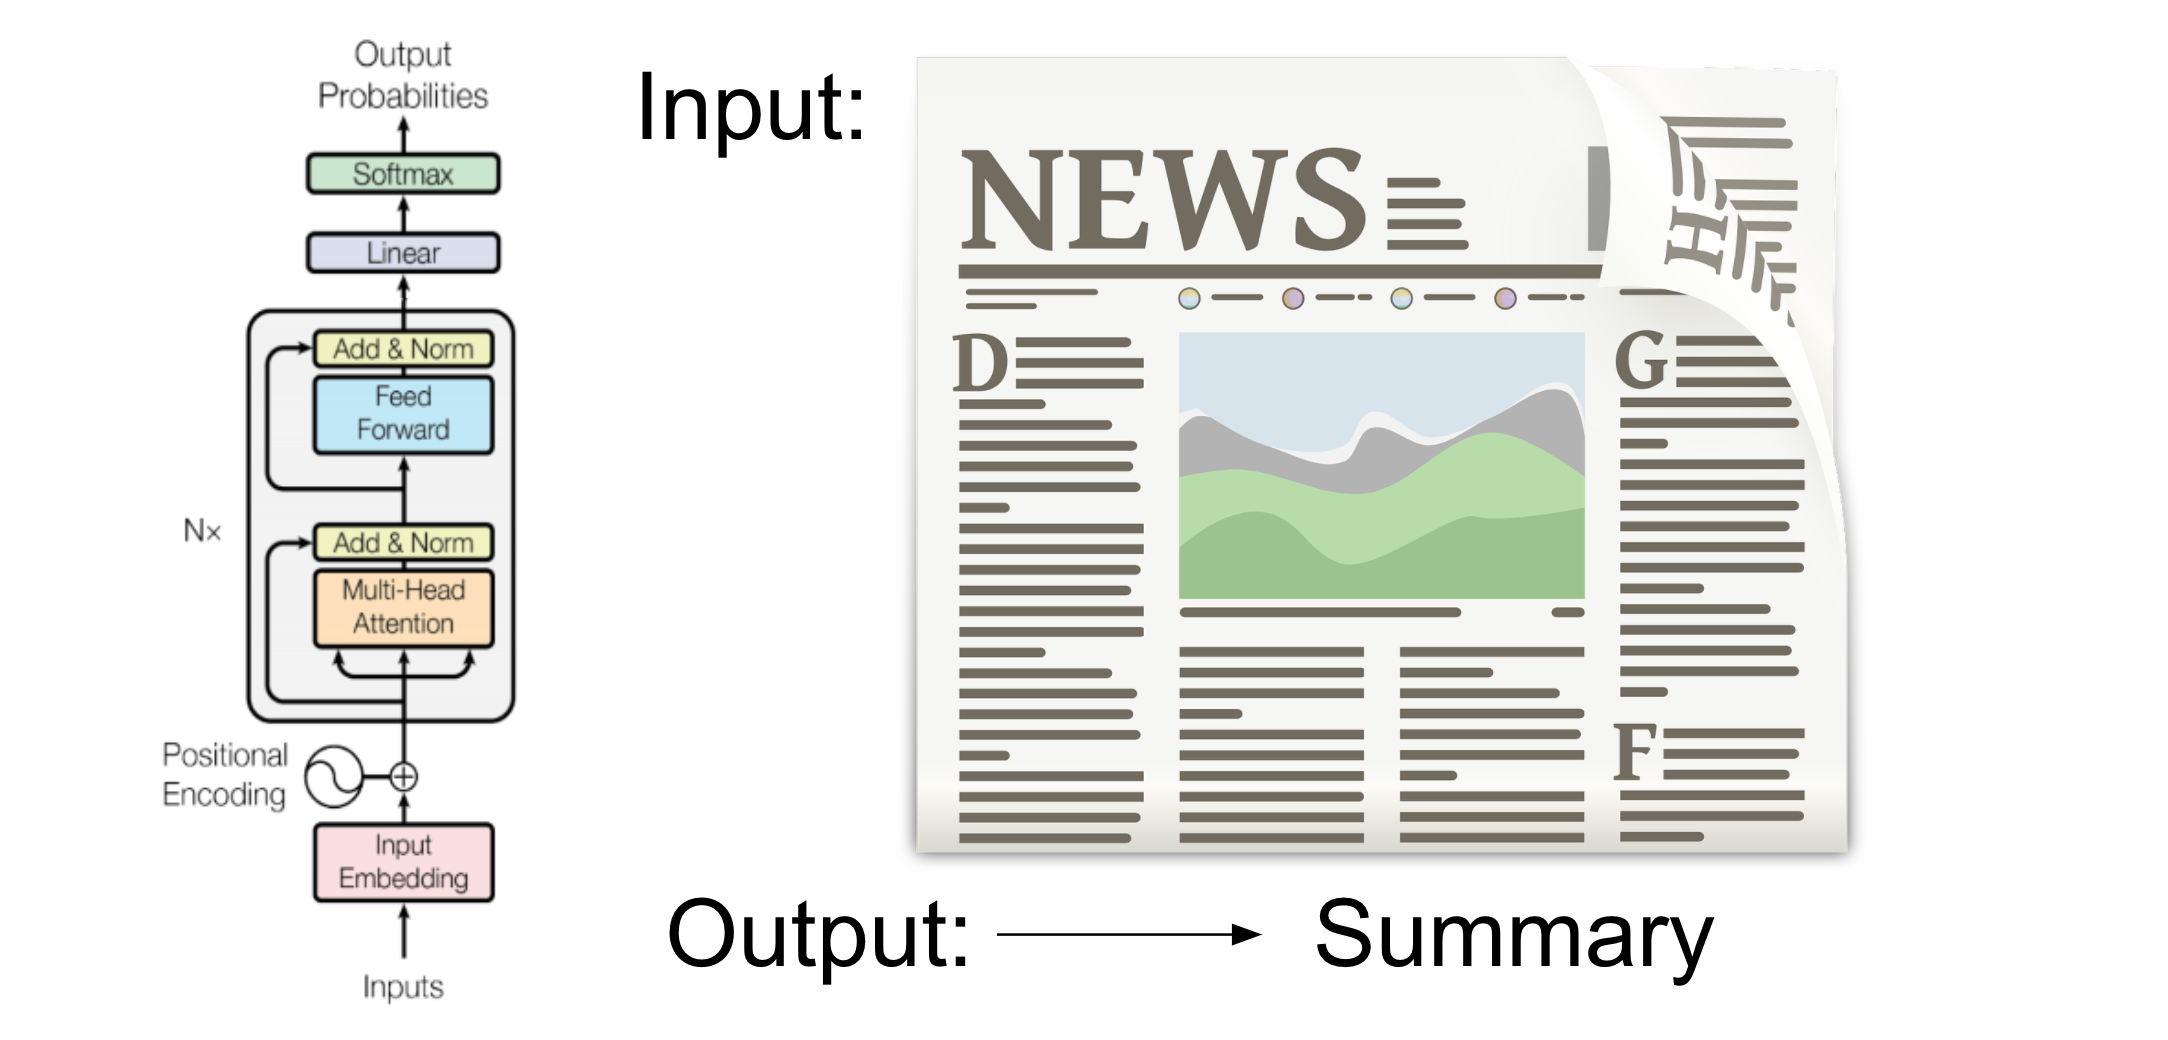</body></html>



## Outline

- [Introduction](#0)
- [Part 1: Importing the dataset](#1)
    - [1.1 Encode & Decode helper functions](#1.1)
    - [1.2 Defining parameters](#1.2)
    - [1.3 Exploring the data](#1.3)
- [Part 2: Summarization with transformer](#2)
    - [2.1 Dot product attention](#2.1)
        - [Exercise 01](#ex01)
    - [2.2 Causal Attention](#2.2)
        - [Exercise 02](#ex02)
    - [2.3 Transformer decoder block](#2.3)
        - [Exercise 03](#ex03)
    - [2.4 Transformer Language model](#2.4)
        - [Exercise 04](#ex04)
- [Part 3: Training](#3)
    - [3.1 Training the model](#3.1)
        - [Exercise 05](#ex05)
- [Part 4: Evaluation](#4)
    - [4.1 Loading in a trained model](#4.1)
- [Part 5: Testing with your own input](#5) 
    - [Exercise 6](#ex06)
    - [5.1 Greedy decoding](#5.1)
        - [Exercise 07](#ex07)

<a name='0'></a>
### Introduction

Summarization is an important task in natural language processing and could be useful for a consumer enterprise. For example, bots can be used to scrape articles, summarize them, and then you can use sentiment analysis to identify the sentiment about certain stocks. Anyways who wants to read an article or a long email today, when you can build a transformer to summarize text for you. Let's get started, by completing this assignment you will learn to:  

- Use built-in functions to preprocess your data
- Implement DotProductAttention
- Implement Causal Attention
- Understand how attention works
- Build the transformer model
- Evaluate your model
- Summarize an article

As you can tell, this model is slightly different than the ones you have already implemented. This is heavily based on attention and does not rely on sequences, which allows for parallel computing. 

In [1]:
import sys
import os
import w2_tests
import numpy as np

import textwrap
wrapper = textwrap.TextWrapper(width=70)

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

In [2]:
!pip list|grep trax

trax                         1.3.9
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


<a name='1'></a>
## Part 1: Importing the dataset

Trax makes it easy to work with Tensorflow's datasets:

In [3]:
# This will download the dataset if no data_dir is specified.
# Downloading and processing can take bit of time,
# so we have the data already in 'data/' for you

# Importing CNN/DailyMail articles dataset
train_stream_fn = trax.data.TFDS('cnn_dailymail',
                                 data_dir='data/',
                                 keys=('article', 'highlights'),
                                 train=True)

# This should be much faster as the data is downloaded already.
eval_stream_fn = trax.data.TFDS('cnn_dailymail',
                                data_dir='data/',
                                keys=('article', 'highlights'),
                                train=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


<a name='1.1'></a>
## 1.1 Tokenize & Detokenize helper functions

Just like in the previous assignment, the cell above loads in the encoder for you. Given any data set, you have to be able to map words to their indices, and indices to their words. The inputs and outputs to your [Trax](https://github.com/google/trax) models are usually tensors of numbers where each number corresponds to a word. If you were to process your data manually, you would have to make use of the following: 

- <span style='color:blue'> word2Ind: </span> a dictionary mapping the word to its index.
- <span style='color:blue'> ind2Word:</span> a dictionary mapping the index to its word.
- <span style='color:blue'> word2Count:</span> a dictionary mapping the word to the number of times it appears. 
- <span style='color:blue'> num_words:</span> total number of words that have appeared. 

Since you have already implemented these in previous assignments of the specialization, we will provide you with helper functions that will do this for you. Run the cell below to get the following functions:

- <span style='color:blue'> tokenize: </span> converts a text sentence to its corresponding token list (i.e. list of indices). Also converts words to subwords.
- <span style='color:blue'> detokenize: </span> converts a token list to its corresponding sentence (i.e. string).

In [4]:
def tokenize(input_str, EOS=1):
    """Input str to features dict, ready for inference"""
  
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_dir='vocab_dir/',
                                      vocab_file='summarize32k.subword.subwords'))
    
    # Mark the end of the sentence with EOS
    return list(inputs) + [EOS]

def detokenize(integers):
    """List of ints to str"""
  
    s = trax.data.detokenize(integers,
                             vocab_dir='vocab_dir/',
                             vocab_file='summarize32k.subword.subwords')
    
    return wrapper.fill(s)

<a name='1.2'></a>

## 1.2 Preprocessing for Language Models: Concatenate It!

This week you will use a language model -- Transformer Decoder -- to solve
an input-output problem. As you know, language models only predict the next
word, they have no notion of inputs. To create a single input suitable for
a language model, we concatenate inputs with targets putting a separator
in between. We also need to create a mask -- with 0s at inputs and 1s at targets -- so that the model is not penalized for mis-predicting the article and only focuses on the summary. See the preprocess function below for how this is done.

In [5]:
# Special tokens
SEP = 0 # Padding or separator token
EOS = 1 # End of sentence token

# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, SEP] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) # Accounting for EOS and SEP
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_dir='vocab_dir/',
                       vocab_file='summarize32k.subword.subwords'),
    # Uses function defined above
    preprocess,
    # Filters out examples longer than 2048
    trax.data.FilterByLength(2048)
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_stream_fn())
eval_stream = input_pipeline(eval_stream_fn())

train_input, train_target, train_mask = next(train_stream)
print(len(train_input),len(train_mask))
assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

564 564


In [6]:
# prints mask, 0s on article, 1s on summary
print(f'Single example mask:\n\n {train_mask}')

Single example mask:

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0

In [7]:
# prints: [Example][<EOS>][<pad>][Example Summary][<EOS>]
print(f'Single example:\n\n {detokenize(train_input)}')

Single example:

 QPR chairman Tony Fernandes has insisted his club can afford not to
win promotion to the Premier League, despite debts of £177.1 million.
Rangers face Derby County in the Championship play-off final at
Wembley on May 24, with Harry Redknapp's side hoping to secure the
£120m pay packet of Premier League promotion. But, should QPR return
to the top tier at the first attempt, they could be forced to pay out
more than half of that in fines under the Football League's Financial
Fair Play regulations. We're ready: Queens Park Rangers chairman Tony
Fernandes says his club doesn't have to win promotion . Off to
Wembley: Rangers won their way through to the play-off final after
extra-time against Wigan . Based on last year's accounts, Rangers
would have to pay £62.1m if they are promoted because their £65.4m
losses were so far in excess of the £8m allowed by the Football
League. Should Redknapp's side stay in the Championship, however, they
would be subjected to a transfer emb

<a name='1.3'></a>

## 1.3 Batching with bucketing

As in the previous week, we use bucketing to create batches of data.

In [8]:
# Bucketing to create batched generators.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 16 sentences of length < 128 , 8 of length < 256,
# 4 of length < 512. And so on. 
boundaries =  [128, 256,  512, 1024]
batch_sizes = [16,    8,    4,    2, 1]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [9]:
# Every execution will result in generation of a different article
# Try running this cell multiple times to see how the length of the examples affects the batch size
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(1, 1618)

In [10]:
# print corresponding integer values
print(input_batch[0])

[ 1680 11703  6133 12461  5485   213  1698  1320   306   527  5323 10366
  6623     4    78  2613     2  4874   809   518   373   101   186   501
 25765  1423     7     5  1098  2284   412   103 18766     5   320  1798
   213  7322  6682   132   256    74   635  1492     3     9 12758  1205
    28 16233 11085  2137   542    28  5955   700   145   213  1859 14183
  1807     2    28   194   102    28 14131   809  5323 10366  6623     4
     7     5   548  1973   947  1343   441   101   186  6531   809   518
  1120     3 20900 18250    58  6857   132     2    28 14380  1019   213
   296     7     5  1080  2694  2684     2   793   213   205     6   655
   782  2684  3513    27  9293  8560   100   285   148 19181   400    25
  8409  2860  1133 27634     4    56  4303     2  1480  1353 22793  2741
  2935  1019   213   422   527 19101  1019   119  2006     7     5 17203
     2   229    36    44  1913   691 17362   320   552    28  2439   979
     2  3531   558 22756   186 16130     2   186 17

Things to notice:
 - First we see the corresponding values of the words.
 - The first 1, which represents the `<EOS>` tag of the article.
 - Followed by a 0, which represents a `<pad>` tag.
 - After the first 0 (`<pad>` tag) the corresponding values are of the words that are used for the summary of the article.
 - The second 1 represents the `<EOS>` tag for the summary.
 - All the trailing 0s represent `<pad>` tags which are appended to maintain consistent length (If you don't see them then it would mean it is already of max length)
 

In [11]:
# print the article and its summary
print('Article:\n\n', detokenize(input_batch[0]))

Article:

 Another suspected suicide bombing struck the southern Russian city of
Volgograd on Monday, killing at least 14 people and further
highlighting Russia's security challenges as it prepares to host the
Winter Olympics in less than six weeks. The explosion hit a trolleybus
near a busy market during the morning rush hour, a day after a blast
at Volgograd's main train station killed 17 people and wounded at
least 35. Vladmir Markin, a spokesman for the country's federal
investigation agency, told the state-run news agency RIA Novosti that
both explosions were terrorist attacks. "This strike, which was
cynically planned for the period of preparations for New Year's
celebrations, is one more attempt by terrorists to open a domestic
front, sow panic and chaos, and trigger religious strife and conflicts
in Russian society," said a statement Monday by Russia's Foreign
Affairs Ministry. "We will not back down and will continue our tough
and consistent offensive" against terrorists, the 

You can see that the data has the following structure:
- <span style='color:blue'> [Article] </span> -> `<EOS>` -> `<pad>` -> <span style='color:blue'> [Article Summary] </span> -> `<EOS>` -> (possibly) multiple `<pad>`

The loss is taken only on the summary using cross_entropy as loss function. 

<a name='2'></a>
# Part 2: Summarization with transformer

Now that we have given you the data generator and have handled the preprocessing for you, it is time for you to build your own model. We saved you some time because we know you have already preprocessed data before in this specialization, so we would rather you spend your time doing the next steps. 

You will be implementing the attention from scratch and then using it in your transformer model. Concretely, you will understand how attention works, how you use it to connect the encoder and the decoder.

<src="images/transformer_decoder_zoomin.png">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>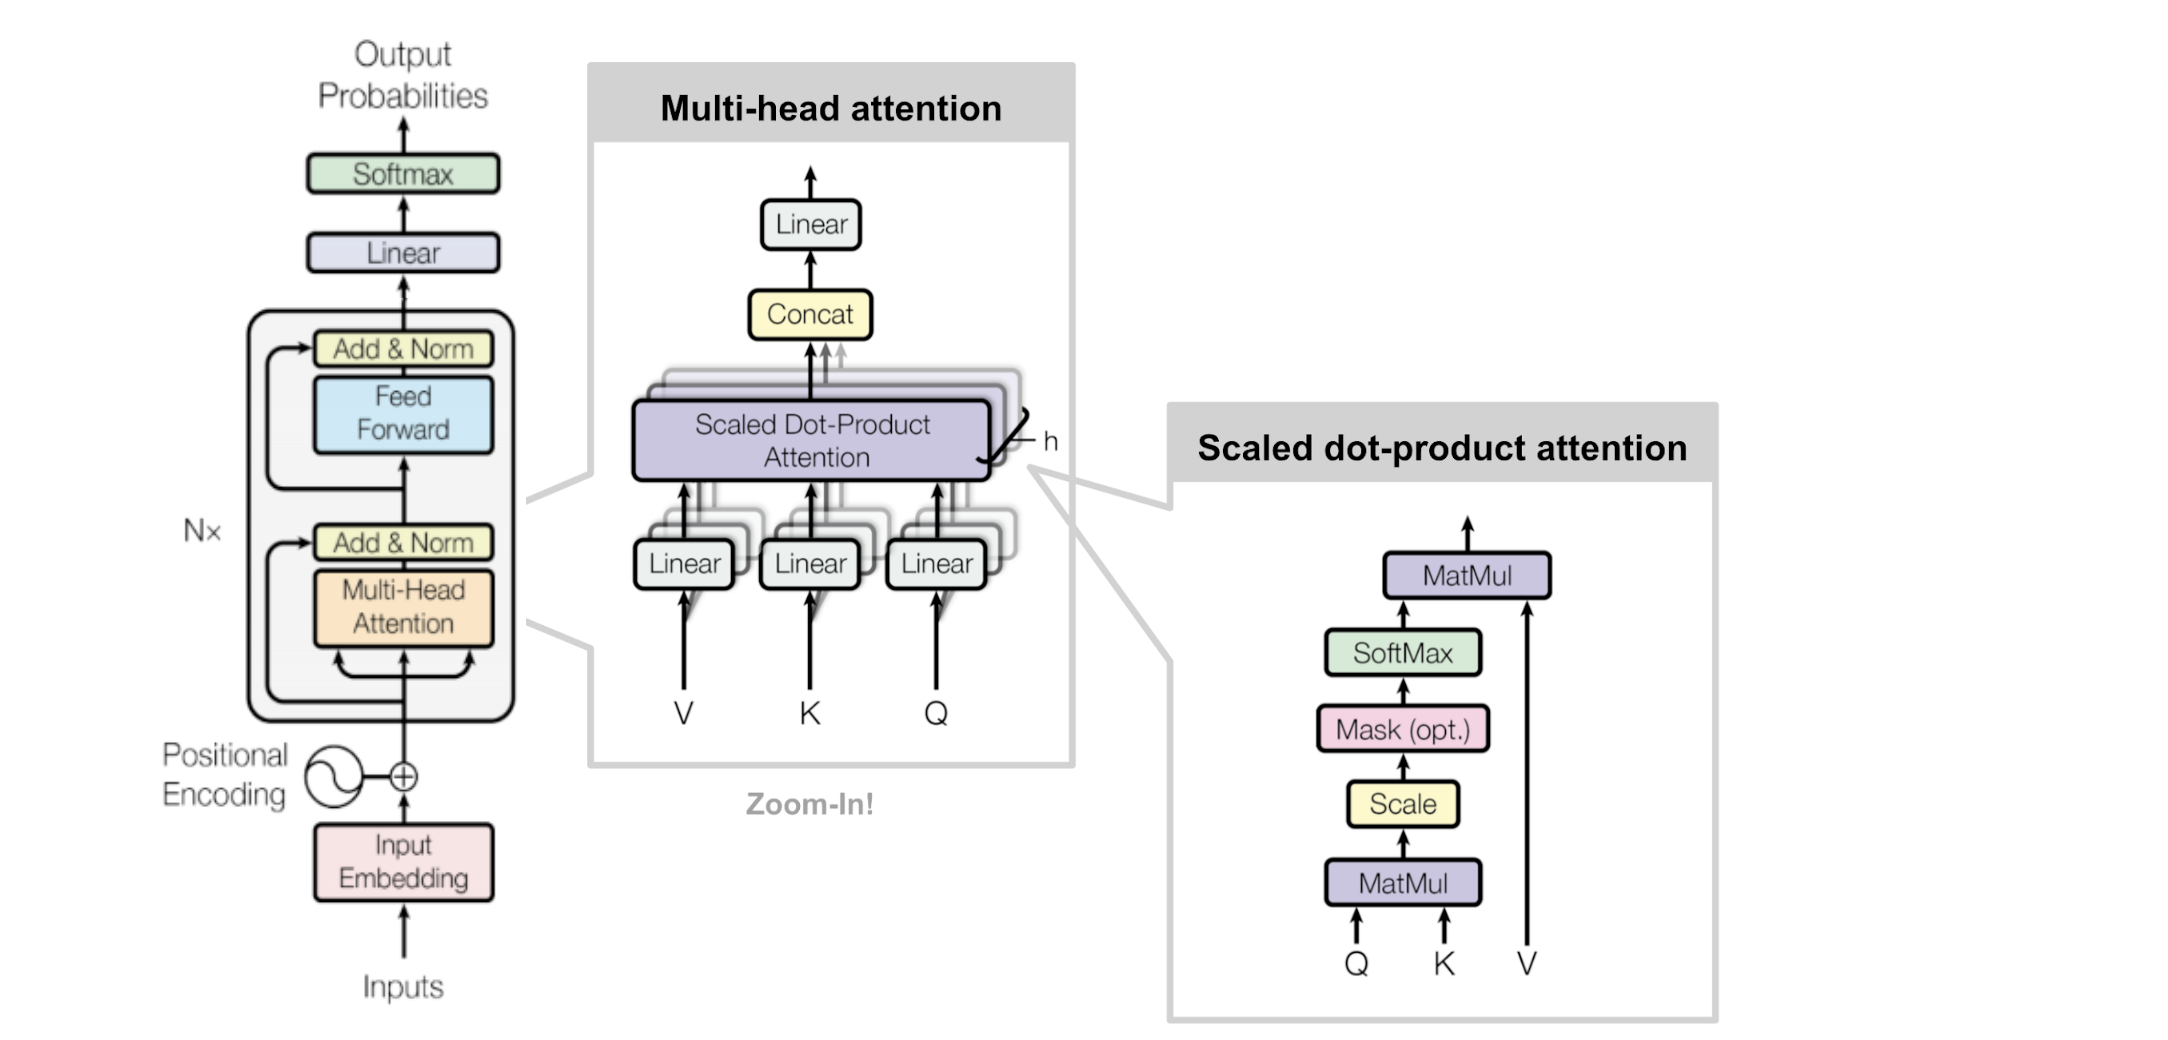</body></html>
<a name='2.1'></a>
## 2.1 Dot product attention 

Now you will implement dot product attention which takes in a query, key, value, and a mask. It returns the output. 

<src ="images/dotproduct.png">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>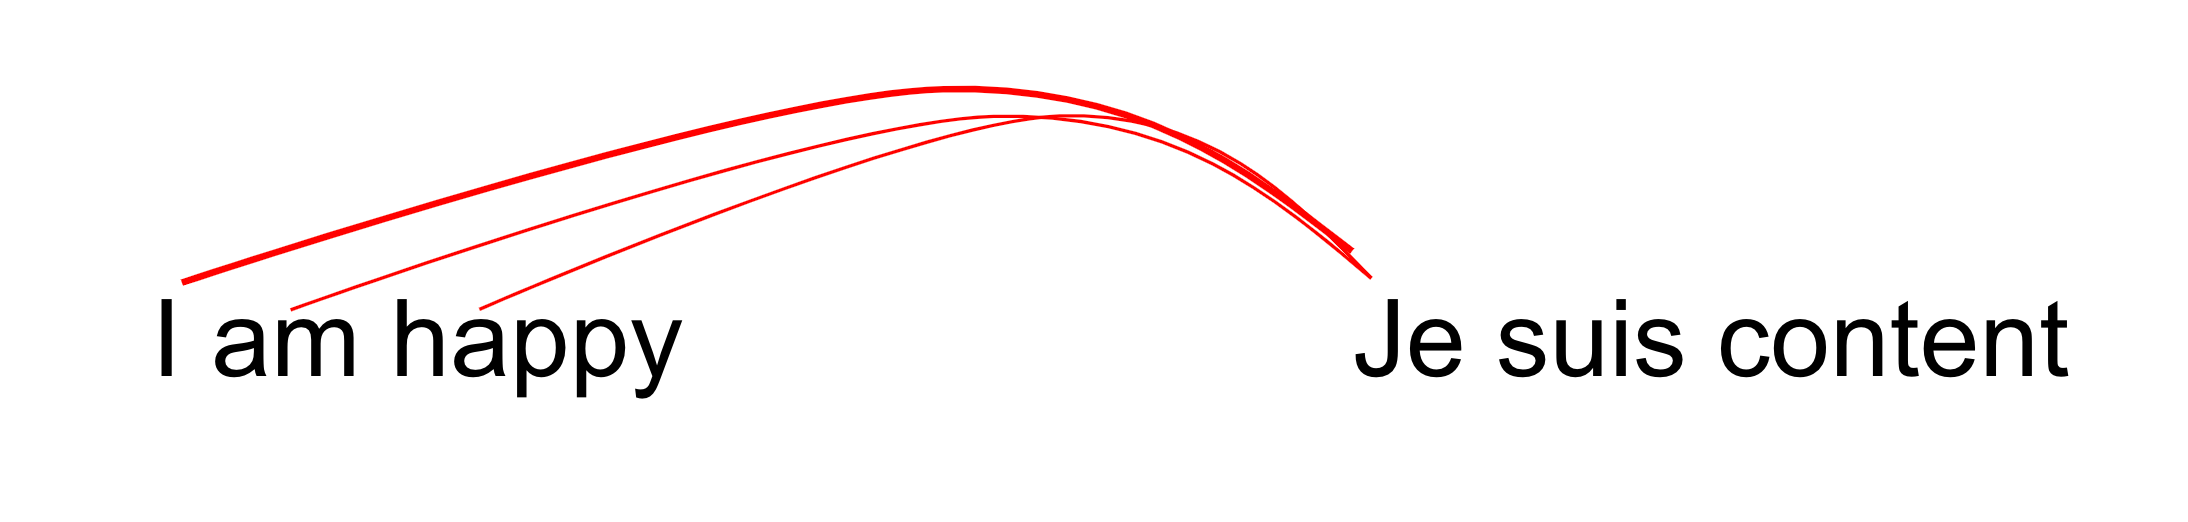</body></html>

Here are some helper functions that will help you create tensors and display useful information:
   - `create_tensor`  creates a `jax numpy array` from a list of lists.
   - `display_tensor` prints out the shape and the actual tensor.

In [12]:
def create_tensor(t):
    """Create tensor from list of lists"""
    return jnp.array(t)


def display_tensor(t, name):
    """Display shape and tensor"""
    print(f'{name} shape: {t.shape}\n')
    print(f'{t}\n')

Before implementing it yourself, you can play around with a toy example of `dot product attention` without the softmax  operation. Technically it would not be `dot product attention` without the softmax but this is done to avoid giving away too much of the answer and the idea is to display these tensors to give you a sense of how they look like.

The formula for attention is this one:

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{1}\
$$

$d_{k}$ stands for the dimension of queries and keys.

The `query`, `key`, `value` and `mask` vectors are provided for this example.

Notice that the masking is done using very negative values that will yield a similar effect to using $-\infty $. 

In [13]:
q = create_tensor([[1, 0, 0], [0, 1, 0]])
display_tensor(q, 'query')
k = create_tensor([[1, 2, 3], [4, 5, 6]])
display_tensor(k, 'key')
v = create_tensor([[0, 1, 0], [1, 0, 1]])
display_tensor(v, 'value')
m = create_tensor([[0, 0], [-1e9, 0]])
display_tensor(m, 'mask')

query shape: (2, 3)

[[1 0 0]
 [0 1 0]]

key shape: (2, 3)

[[1 2 3]
 [4 5 6]]

value shape: (2, 3)

[[0 1 0]
 [1 0 1]]

mask shape: (2, 2)

[[ 0.e+00  0.e+00]
 [-1.e+09  0.e+00]]



**Expected Output:**
```CPP
query shape: (2, 3)

[[1 0 0]
 [0 1 0]]

key shape: (2, 3)

[[1 2 3]
 [4 5 6]]

value shape: (2, 3)

[[0 1 0]
 [1 0 1]]

mask shape: (2, 2)

[[ 0.e+00  0.e+00]
 [-1.e+09  0.e+00]]

```

In [14]:
q_dot_k = q @ k.T / jnp.sqrt(3)
display_tensor(q_dot_k, 'query dot key')

query dot key shape: (2, 2)

[[0.57735026 2.309401  ]
 [1.1547005  2.8867514 ]]



**Expected Output:**
```CPP
query dot key shape: (2, 2)

[[0.57735026 2.309401  ]
 [1.1547005  2.8867514 ]]
```

In [15]:
masked = q_dot_k + m
display_tensor(masked, 'masked query dot key')

masked query dot key shape: (2, 2)

[[ 5.7735026e-01  2.3094010e+00]
 [-1.0000000e+09  2.8867514e+00]]



**Expected Output:**
```CPP
masked query dot key shape: (2, 2)

[[ 5.7735026e-01  2.3094010e+00]
 [-1.0000000e+09  2.8867514e+00]]
```

In [16]:
display_tensor(masked @ v, 'masked query dot key dot value')

masked query dot key dot value shape: (2, 3)

[[ 2.3094010e+00  5.7735026e-01  2.3094010e+00]
 [ 2.8867514e+00 -1.0000000e+09  2.8867514e+00]]



**Expected Output:**
```CPP
masked query dot key dot value shape: (2, 3)

[[ 2.3094010e+00  5.7735026e-01  2.3094010e+00]
 [ 2.8867514e+00 -1.0000000e+09  2.8867514e+00]]
```

In order to use the previous dummy tensors to test some of the graded functions, a batch dimension should be added to them so they mimic the shape of real-life examples. The mask is also replaced by a version of it that resembles the one that is used by trax:

In [17]:
q_with_batch = q[None,:]
display_tensor(q_with_batch, 'query with batch dim')
k_with_batch = k[None,:]
display_tensor(k_with_batch, 'key with batch dim')
v_with_batch = v[None,:]
display_tensor(v_with_batch, 'value with batch dim')
m_bool = create_tensor([[True, True], [False, True]])
display_tensor(m_bool, 'boolean mask')

query with batch dim shape: (1, 2, 3)

[[[1 0 0]
  [0 1 0]]]

key with batch dim shape: (1, 2, 3)

[[[1 2 3]
  [4 5 6]]]

value with batch dim shape: (1, 2, 3)

[[[0 1 0]
  [1 0 1]]]

boolean mask shape: (2, 2)

[[ True  True]
 [False  True]]



**Expected Output:**
```CPP
query with batch dim shape: (1, 2, 3)

[[[1 0 0]
  [0 1 0]]]

key with batch dim shape: (1, 2, 3)

[[[1 2 3]
  [4 5 6]]]

value with batch dim shape: (1, 2, 3)

[[[0 1 0]
  [1 0 1]]]

boolean mask shape: (2, 2)

[[ True  True]
 [False  True]]
```

<a name='ex01'></a>
### Exercise 01

**Instructions:** Implement the dot product attention. Concretely, implement the following equation


$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{1}\
$$

$Q$ - query, 
$K$ - key, 
$V$ - values, 
$M$ - mask, 
${d_k}$ - depth/dimension of the queries and keys (used for scaling down)

You can implement this formula either by `trax` numpy (trax.math.numpy) or regular `numpy` but it is recommended to use `jnp`.

Something to take into consideration is that within trax, the masks are tensors of `True/False` values not 0's and $-\infty$ as in the previous example. Within the graded function don't think of applying the mask by summing up matrices, instead use `jnp.where()` and treat the **mask as a tensor of boolean values with `False` for values that need to be masked and True for the ones that don't.**

Also take into account that the real tensors are far more complex than the toy ones you just played with. Because of this avoid using shortened operations such as `@` for dot product or `.T` for transposing. Use `jnp.matmul()` and `jnp.swapaxes()` instead.

This is the self-attention block for the transformer decoder. Good luck!  

In [18]:
# UNQ_C1
# GRADED FUNCTION: DotProductAttention
def DotProductAttention(query, key, value, mask):
    """Dot product self-attention.
    Args:
        query (jax.interpreters.xla.DeviceArray): array of query representations with shape (L_q by d)
        key (jax.interpreters.xla.DeviceArray): array of key representations with shape (L_k by d)
        value (jax.interpreters.xla.DeviceArray): array of value representations with shape (L_k by d) where L_v = L_k
        mask (jax.interpreters.xla.DeviceArray): attention-mask, gates attention with shape (L_q by L_k)

    Returns:
        jax.interpreters.xla.DeviceArray: Self-attention array for q, k, v arrays. (L_q by L_k)
    """

    assert query.shape[-1] == key.shape[-1] == value.shape[-1], "Embedding dimensions of q, k, v aren't all the same"

    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR CODE) ###
    # Save depth/dimension of the query embedding for scaling down the dot product
    depth = key.shape[-1]

    # Calculate scaled query key dot product according to formula above
    dots = jnp.matmul(query, jnp.swapaxes(key, -1, -2)) / jnp.sqrt(depth)
    
    # Apply the mask
    if mask is not None: # You do not need to replace the 'None' on this line
        dots = jnp.where(mask, dots, jnp.full_like(dots, -1e9))
    
    # Softmax formula implementation
    # Use trax.math.logsumexp of masked_qkT to avoid underflow by division by large numbers
    # Note: softmax = None
    logsumexp = trax.fastmath.logsumexp(dots, axis=-1, keepdims=True)

    # Take exponential of dots minus logsumexp to get softmax
    # Use jnp.exp()
    dots = jnp.exp(dots - logsumexp)

    # Multiply dots by value to get self-attention
    # Use jnp.matmul()
    attention = jnp.matmul(dots, value)

    ## END CODE HERE ###
    
    return attention

In [19]:
DotProductAttention(q_with_batch, k_with_batch, v_with_batch, m_bool)

DeviceArray([[[0.8496746 , 0.15032545, 0.8496746 ],
              [1.        , 0.        , 1.        ]]], dtype=float32)

**Expected Output:**
```CPP
DeviceArray([[[0.8496746 , 0.15032545, 0.8496746 ],
              [1.        , 0.        , 1.        ]]], dtype=float32)
```    

In [20]:
# UNIT TEST
# test DotProductAttention
w2_tests.test_DotProductAttention(DotProductAttention)

 All tests passed


<a name='2.2'></a>

## 2.2 Causal Attention

Now you are going to implement causal attention: multi-headed attention with a mask to attend only to words that occurred before. 

<img src = "images/causal.png">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>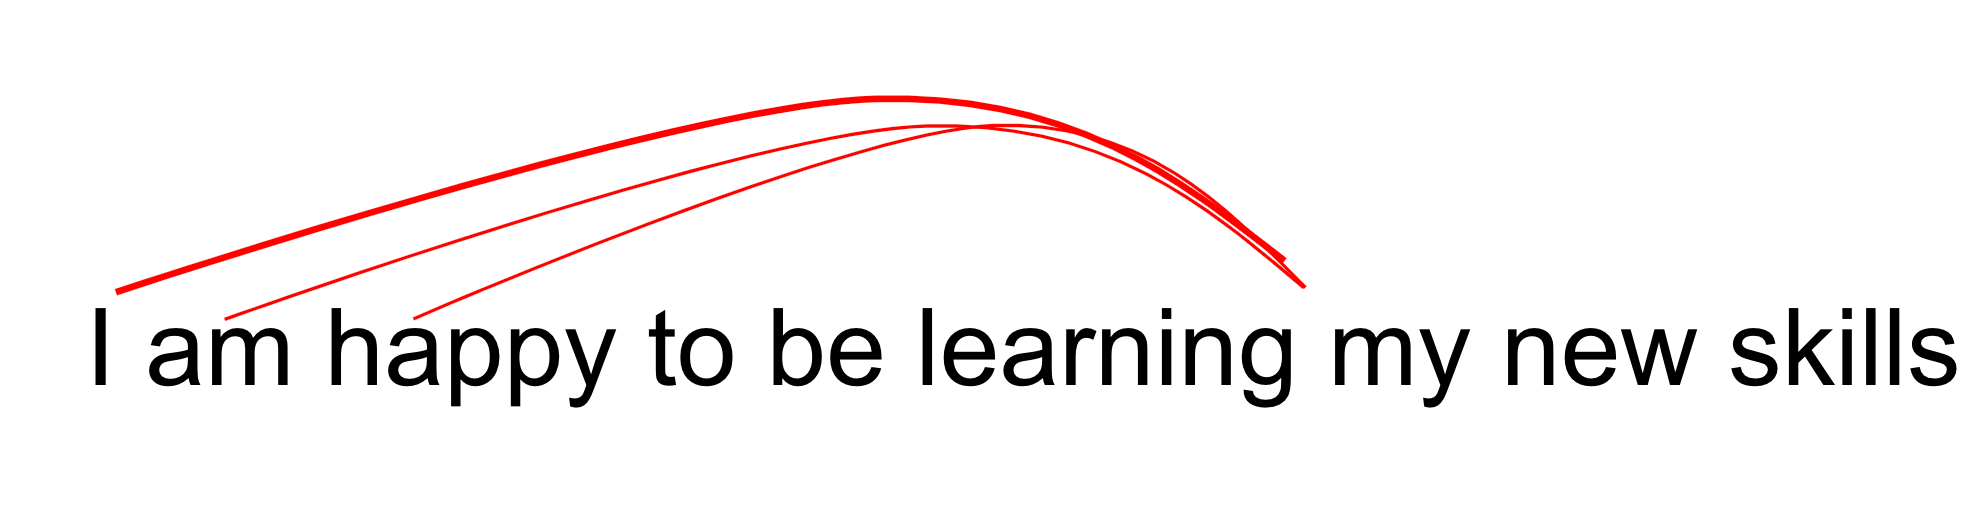</body></html>
In the image above, a word can see everything that is before it, but not what is after it. To implement causal attention, you will have to transform vectors and do many reshapes. You will need to implement the functions below.


<a name='ex02'></a>
### Exercise 02

Implement the following functions that will be needed for Causal Attention:

- <span style='color:blue'> compute_attention_heads </span>: Gets an input $x$ of dimension (n_batch, seqlen, n_heads $\times$ d_head) and splits the last (depth) dimension and stacks it to the zeroth dimension to allow matrix multiplication (n_batch $\times$ n_heads, seqlen, d_head).
- <span style='color:blue'> dot_product_self_attention </span>: Creates a mask matrix with `False` values above the diagonal and `True` values below and calls DotProductAttention which implements dot product self attention.
- <span style='color:blue'> compute_attention_output </span>: Undoes compute_attention_heads by splitting first (vertical) dimension and stacking in the last (depth) dimension (n_batch, seqlen, n_heads $\times$ d_head). These operations concatenate (stack/merge) the heads. 

Next there are some toy tensors which may serve to give you an idea of the data shapes and opperations involved in Causal Attention. They are also useful to test out your functions! 

In [21]:
tensor2d = create_tensor(q)
display_tensor(tensor2d, 'query matrix (2D tensor)')

tensor4d2b = create_tensor([[q, q], [q, q]])
display_tensor(tensor4d2b, 'batch of two (multi-head) collections of query matrices (4D tensor)')

tensor3dc = create_tensor([jnp.concatenate([q, q], axis = -1)])
display_tensor(tensor3dc, 'one batch of concatenated heads of query matrices (3d tensor)')

tensor3dc3b = create_tensor([jnp.concatenate([q, q], axis = -1), jnp.concatenate([q, q], axis = -1), jnp.concatenate([q, q], axis = -1)])
display_tensor(tensor3dc3b, 'three batches of concatenated heads of query matrices (3d tensor)')

query matrix (2D tensor) shape: (2, 3)

[[1 0 0]
 [0 1 0]]

batch of two (multi-head) collections of query matrices (4D tensor) shape: (2, 2, 2, 3)

[[[[1 0 0]
   [0 1 0]]

  [[1 0 0]
   [0 1 0]]]


 [[[1 0 0]
   [0 1 0]]

  [[1 0 0]
   [0 1 0]]]]

one batch of concatenated heads of query matrices (3d tensor) shape: (1, 2, 6)

[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]

three batches of concatenated heads of query matrices (3d tensor) shape: (3, 2, 6)

[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]



It is important to know that the following 3 functions would normally be defined within the `CausalAttention` function further below. 

However this makes these functions harder to test. Because of this, these functions are shown individually using a `closure` (when necessary) that simulates them being inside of the `CausalAttention` function. This is done because they rely on some variables that can be accessed from within `CausalAttention`.

### Support Functions

<span style='color:blue'> compute_attention_heads </span>: Gets an input $x$ of dimension (n_batch, seqlen, n_heads $\times$ d_head) and splits the last (depth) dimension and stacks it to the zeroth dimension to allow matrix multiplication (n_batch $\times$ n_heads, seqlen, d_head).

**For the closures you only have to fill the inner function.**

In [22]:
# UNQ_C2
# GRADED FUNCTION: compute_attention_heads_closure
def compute_attention_heads_closure(n_heads, d_head):
    """ Function that simulates environment inside CausalAttention function.
    Args:
        d_head (int):  dimensionality of heads
        n_heads (int): number of attention heads
    Returns:
        function: compute_attention_heads function
    """

    def compute_attention_heads(x):
        """ Compute the attention heads.
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (n_batch, seqlen, n_heads X d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (n_batch X n_heads, seqlen, d_head).
        """
        ### START CODE HERE ###
        # (REPLACE INSTANCES OF 'None' WITH YOUR CODE)
        
        # Size of the x's batch dimension
        batch_size = x.shape[0]
        # Length of the sequence
        # Should be size of x's first dimension without counting the batch dim
        seqlen = x.shape[1]
        # Reshape x using jnp.reshape()
        # n_batch, seqlen, n_heads*d_head -> n_batch, seqlen, n_heads, d_head
        x = jnp.reshape(x, (batch_size, seqlen, n_heads, d_head))
        # Transpose x using jnp.transpose()
        # n_batch, seqlen, n_heads, d_head -> n_batch, n_heads, seqlen, d_head
        # Note that the values within the tuple are the indexes of the dimensions of x and you must rearrange them
        x = jnp.transpose(x, (0, 2, 1, 3))
        # Reshape x using jnp.reshape()
        # n_batch, n_heads, seqlen, d_head -> n_batch*n_heads, seqlen, d_head
        x = jnp.reshape(x, (-1, seqlen, d_head))
        
        ### END CODE HERE ###

        return x
    return compute_attention_heads

In [23]:
display_tensor(tensor3dc3b, "input tensor")
result_cah = compute_attention_heads_closure(2,3)(tensor3dc3b)
display_tensor(result_cah, "output tensor")

input tensor shape: (3, 2, 6)

[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]

output tensor shape: (6, 2, 3)

[[[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]]



**Expected Output:**
```CPP
input tensor shape: (3, 2, 6)

[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]

output tensor shape: (6, 2, 3)

[[[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]]
```

In [24]:
# UNIT TEST
# test compute_attention_heads_closure
w2_tests.test_compute_attention_heads_closure(compute_attention_heads_closure)

 All tests passed


<span style='color:blue'> dot_product_self_attention </span>: Creates a mask matrix with `False` values above the diagonal and `True` values below and calls DotProductAttention which implements dot product self attention.

In [25]:
# UNQ_C3
# GRADED FUNCTION: dot_product_self_attention
def dot_product_self_attention(q, k, v):
    """ Masked dot product self attention.
    Args:
        q (jax.interpreters.xla.DeviceArray): queries.
        k (jax.interpreters.xla.DeviceArray): keys.
        v (jax.interpreters.xla.DeviceArray): values.
    Returns:
        jax.interpreters.xla.DeviceArray: masked dot product self attention tensor.
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # Hint: mask size should be equal to L_q. Remember that q has shape (batch_size, L_q, d)
    mask_size = q.shape[-2]


    # Creates a matrix with ones below the diagonal and 0s above. It should have shape (1, mask_size, mask_size)
    # Notice that 1's and 0's get casted to True/False by setting dtype to jnp.bool_
    # Use jnp.tril() - Lower triangle of an array and jnp.ones()
    mask = jnp.tril(jnp.ones((1, mask_size, mask_size), dtype=jnp.bool_), k=0)
    
    ### END CODE HERE ###
    
    return DotProductAttention(q, k, v, mask)

In [26]:
dot_product_self_attention(q_with_batch, k_with_batch, v_with_batch)

DeviceArray([[[0.        , 1.        , 0.        ],
              [0.8496746 , 0.15032543, 0.8496746 ]]], dtype=float32)

**Expected Output:**
```CPP
DeviceArray([[[0.        , 1.        , 0.        ],
              [0.8496746 , 0.15032543, 0.8496746 ]]], dtype=float32)
```

In [27]:
# UNIT TEST
# test dot_product_self_attention
w2_tests.test_dot_product_self_attention(dot_product_self_attention)

 All tests passed


<span style='color:blue'> compute_attention_output </span>: Undoes compute_attention_heads by splitting first (vertical) dimension and stacking in the last (depth) dimension (n_batch, seqlen, n_heads $\times$ d_head). These operations concatenate (stack/merge) the heads. 

In [28]:
# UNQ_C4
# GRADED FUNCTION: compute_attention_output_closure
def compute_attention_output_closure(n_heads, d_head):
    """ Function that simulates environment inside CausalAttention function.
    Args:
        d_head (int):  dimensionality of heads
        n_heads (int): number of attention heads
    Returns:
        function: compute_attention_output function
    """
    
    def compute_attention_output(x):
        """ Compute the attention output.
        Args:
            x (jax.interpreters.xla.DeviceArray): tensor with shape (n_batch X n_heads, seqlen, d_head).
        Returns:
            jax.interpreters.xla.DeviceArray: reshaped tensor with shape (n_batch, seqlen, n_heads X d_head).
        """
        ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR CODE) ###
        
        # Length of the sequence
        # Should be size of x's first dimension without counting the batch dim
        seqlen = x.shape[1]
        # Reshape x using jnp.reshape() to shape (n_batch, n_heads, seqlen, d_head)
        x = jnp.reshape(x, ((-1, n_heads, seqlen, d_head)))
        # Transpose x using jnp.transpose() to shape (n_batch, seqlen, n_heads, d_head)
        x = jnp.transpose(x, (0, 2, 1, 3))            
        
        ### END CODE HERE ###
        
        # Reshape to allow to concatenate the heads
        return jnp.reshape(x, (-1, seqlen, n_heads * d_head))
    return compute_attention_output

In [29]:
display_tensor(result_cah, "input tensor")
result_cao = compute_attention_output_closure(2,3)(result_cah)
display_tensor(result_cao, "output tensor")

input tensor shape: (6, 2, 3)

[[[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]]

output tensor shape: (3, 2, 6)

[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]



**Expected Output:**
```CPP
input tensor shape: (6, 2, 3)

[[[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]

 [[1 0 0]
  [0 1 0]]]

output tensor shape: (3, 2, 6)

[[[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]

 [[1 0 0 1 0 0]
  [0 1 0 0 1 0]]]
```

In [30]:
# UNIT TEST
# test compute_attention_output_closure
w2_tests.test_compute_attention_output_closure(compute_attention_output_closure)

 All tests passed


### Causal Attention Function

Now it is time for you to put everything together within the `CausalAttention` or Masked multi-head attention function:

<img src = "images/masked-attention.png"> 
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>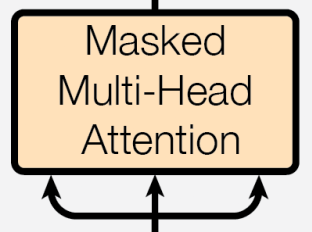</body></html>
**Instructions:** Implement the causal attention.
Your model returns the causal attention through a $tl.Serial$ with the following:

- <span style='color:blue'> [tl.Branch](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Branch) </span>: consisting of 3 [tl.Dense(d_feature), ComputeAttentionHeads] to account for the queries, keys, and values.
- <span style='color:blue'> [tl.Fn](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn)</span>: Takes in dot_product_self_attention function and uses it to compute the dot product using $Q$, $K$, $V$.
- <span style='color:blue'> [tl.Fn](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn)</span>: Takes in compute_attention_output_closure to allow for parallel computing.
- <span style='color:blue'> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense)</span>: Final Dense layer, with dimension `d_feature`.

Remember that in order for trax to properly handle the functions you just defined, they need to be added as layers using the [`tl.Fn()`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.base.Fn) function. 

In [31]:
# UNQ_C5
# GRADED FUNCTION: CausalAttention
def CausalAttention(d_feature, 
                    n_heads, 
                    compute_attention_heads_closure=compute_attention_heads_closure,
                    dot_product_self_attention=dot_product_self_attention,
                    compute_attention_output_closure=compute_attention_output_closure,
                    mode='train'):
    """Transformer-style multi-headed causal attention.

    Args:
        d_feature (int):  dimensionality of feature embedding.
        n_heads (int): number of attention heads.
        compute_attention_heads_closure (function): Closure around compute_attention heads.
        dot_product_self_attention (function): dot_product_self_attention function. 
        compute_attention_output_closure (function): Closure around compute_attention_output. 
        mode (str): 'train' or 'eval'.

    Returns:
        trax.layers.combinators.Serial: Multi-headed self-attention model.
    """
    
    assert d_feature % n_heads == 0
    d_head = d_feature // n_heads

    ### START CODE HERE ###
    # (REPLACE INSTANCES OF 'None' WITH YOUR CODE)
    
    # HINT: The second argument to tl.Fn() is an uncalled function (without the parentheses)
    # Since you are dealing with closures you might need to call the outer 
    # function with the correct parameters to get the actual uncalled function.
    ComputeAttentionHeads = tl.Fn('AttnHeads', compute_attention_heads_closure(n_heads, d_head), n_out=1)
        

    return tl.Serial(
        tl.Branch( # creates three towers for one input, takes activations and creates queries keys and values
            [tl.Dense(d_feature), ComputeAttentionHeads], # queries
            [tl.Dense(d_feature), ComputeAttentionHeads], # keys
            [tl.Dense(d_feature), ComputeAttentionHeads] # values
        ),
        
        tl.Fn('DotProductAttn', dot_product_self_attention, n_out=1), # takes QKV
        # HINT: The second argument to tl.Fn() is an uncalled function
        # Since you are dealing with closures you might need to call the outer 
        # function with the correct parameters to get the actual uncalled function.
        tl.Fn('AttnOutput', compute_attention_output_closure(n_heads, d_head), n_out=1), # to allow for parallel
        tl.Dense(d_feature)
    )

    ### END CODE HERE ###

In [32]:
# Take a look at the causal attention model
print(CausalAttention(d_feature=512, n_heads=8))

Serial[
  Branch_out3[
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
  ]
  DotProductAttn_in3
  AttnOutput
  Dense_512
]


**Expected Output:**
```CPP
Serial[
  Branch_out3[
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
    [Dense_512, AttnHeads]
  ]
  DotProductAttn_in3
  AttnOutput
  Dense_512
]
```

In [33]:
# UNIT TEST
# test CausalAttention
w2_tests.test_CausalAttention(CausalAttention)

 All tests passed


<a name='2.3'></a>

## 2.3 Transformer decoder block

Now that you have implemented the causal part of the transformer, you will implement the transformer decoder block. Concretely you will be implementing this image now.

<img src = "images/transformer_decoder_1.png" style = "height:300px"> 
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>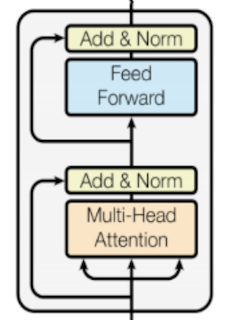</body></html>
To implement this function, you will have to call the `CausalAttention` or Masked multi-head attention function you implemented above. You will have to add a feedforward which consists of: 

- <span style='color:blue'> [tl.LayerNorm](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm) </span>: used to layer normalize
- <span style='color:blue'> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) </span>: the dense layer
- <span style='color:blue'> [ff_activation](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.activation_fns.Relu) </span>: feed forward activation (we use ReLu) here.
- <span style='color:blue'> [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout) </span>: dropout layer
- <span style='color:blue'> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) </span>: dense layer
- <span style='color:blue'> [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout) </span>: dropout layer

Finally once you implement the feedforward, you can go ahead and implement the entire block using: 

- <span style='color:blue'> [tl.Residual](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) </span>: takes in the tl.LayerNorm(), causal attention block, tl.dropout. 

- <span style='color:blue'> [tl.Residual](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Residual) </span>: takes in the feedforward block you will implement. 

<a name='ex03'></a>
### Exercise 03
**Instructions:** Implement the transformer decoder block. Good luck!

In [34]:
# UNQ_C6
# GRADED FUNCTION: DecoderBlock
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR CODE) ###
    
    # Create masked multi-head attention block using CausalAttention function
    causal_attention = CausalAttention( 
                        d_model,
                        n_heads=n_heads,
                        mode=mode
                        )

    # Create feed-forward block (list) with two dense layers with dropout and input normalized
    feed_forward = [ 
        # Normalize layer inputs
        tl.LayerNorm(),
        # Add first feed forward (dense) layer (don't forget to set the correct value for n_units)
        tl.Dense(d_ff),
        # Add activation function passed in as a parameter (you need to call it!)
        ff_activation(), # Generally ReLU
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode),
        # Add second feed forward layer (don't forget to set the correct value for n_units)
        tl.Dense(d_model),
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode)
    ]

    # Add list of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(),
          # Add causal attention block previously defined (without parentheses)
          causal_attention,
          # Add dropout with rate and mode specified
          tl.Dropout(rate=dropout, mode=mode)
        ),
      tl.Residual(
          # Add feed forward block (without parentheses)
          feed_forward
        ),
      ]
    ### END CODE HERE ###

In [35]:
# Take a look at the decoder block
print(DecoderBlock(d_model=512, d_ff=2048, n_heads=8, dropout=0.1, mode='train', ff_activation=tl.Relu))

[Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Serial[
        Branch_out3[
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
        ]
        DotProductAttn_in3
        AttnOutput
        Dense_512
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Serial[
        Relu
      ]
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]


**Expected Output:**
```CPP
[Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Serial[
        Branch_out3[
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
          [Dense_512, AttnHeads]
        ]
        DotProductAttn_in3
        AttnOutput
        Dense_512
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Serial[
        Relu
      ]
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]
```

In [36]:
# UNIT TEST
# test DecoderBlock
w2_tests.test_DecoderBlock(DecoderBlock)

 All tests passed


<a name='2.4'></a>
## 2.4 Transformer Language Model

You will now bring it all together. In this part you will use all the subcomponents you previously built to make the final model. Concretely, here is the image you will be implementing. 
<img src = "images/transformer_decoder.png" style = "height:400px">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>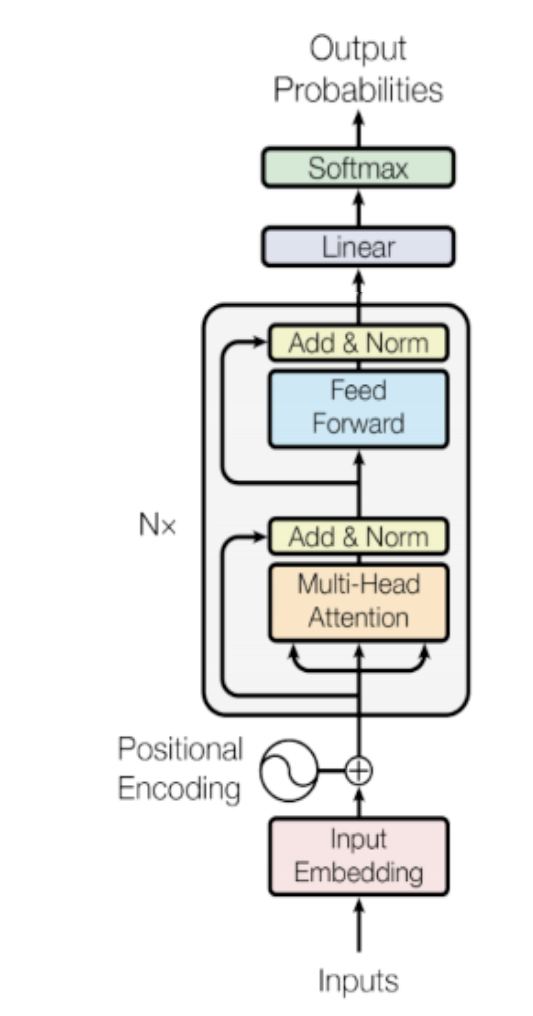</body></html>
    
<a name='ex04'></a>
### Exercise 04
**Instructions:** Previously you coded the decoder block. Now you will code the transformer language model. Here is what you will need. 

- <span style="color:blue"> positional_enconder </span>- a list containing the following layers:
    - <span style="color:blue"> [tl.Embedding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding)
    - <span style="color:blue"> [tl.Dropout](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dropout)
    - <span style="color:blue"> [tl.PositionalEncoding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.PositionalEncoding)

- A list of `n_layers` <span style="color:blue"> decoder blocks</span>.
- <span style="color:blue"> [tl.Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.combinators.Serial): </span> takes in the following layers or lists of layers:
    - <span style="color:blue"> [tl.ShiftRight](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.attention.ShiftRight): </span>: shift the tensor to the right by padding on axis 1.
    - <span style="color:blue"> positional_encoder </span>: encodes the text positions.
    - <span style="color:blue"> decoder_blocks </span>: the ones you created.
    - <span style="color:blue"> [tl.LayerNorm](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.normalization.LayerNorm) </span>: a layer norm.
    - <span style="color:blue"> [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense) </span>: takes in the vocab_size.
    - <span style="color:blue"> [tl.LogSoftmax](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax) </span>: to predict.
    
Go go go!! You can do it :)



In [37]:
# UNQ_C7
# GRADED FUNCTION: TransformerLM
def TransformerLM(vocab_size=33300,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR CODE) ###
    
    # Embedding inputs and positional encoder
    positional_encoder = [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode),
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)]

    # Create stack (list) of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [ 
        DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)]

    # Create the complete model as written in the figure
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), # Specify the mode!
        # Add positional encoder
        positional_encoder,
        # Add decoder blocks
        decoder_blocks,
        # Normalize layer
        tl.LayerNorm(),

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size),
        # Get probabilities with Logsoftmax
        tl.LogSoftmax()
    )

    ### END CODE HERE ###

In [38]:
# Take a look at the Transformer
print(TransformerLM(n_layers=1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_33300_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
          ]
          DotProductAttn_in3
          AttnOutput
          Dense_512
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_33300
  LogSoftmax
]


**Expected Output:**
```CPP
Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_33300_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
            [Dense_512, AttnHeads]
          ]
          DotProductAttn_in3
          AttnOutput
          Dense_512
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_33300
  LogSoftmax
]
```

In [39]:
# UNIT TEST
# test TransformerLM
w2_tests.test_TransformerLM(TransformerLM)

 All tests passed


<a name='3'></a>
# Part 3: Training

Now you are going to train your model. As usual, you have to define the cost function, the optimizer, and decide whether you will be training it on a `gpu` or `cpu`. In this case, you will train your model on a cpu for a few steps and we will load in a pre-trained model that you can use to predict with your own words.

<a name='3.1'></a>
### 3.1 Training the model

You will now write a function that takes in your model and trains it. To train your model you have to decide how many times you want to iterate over the entire data set. Each iteration is defined as an `epoch`. For each epoch, you have to go over all the data, using your training iterator.

<a name='ex05'></a>
### Exercise 05
**Instructions:** Implement the `train_model` program below to train the neural network above. Here is a list of things you should do:

- Create the train task by calling [`trax.supervised.training.TrainTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.TrainTask) and pass in the following: 
    - <span style='color:blue'> labeled_data </span> = train_gen
    - <span style='color:blue'> loss_fn </span> = [tl.CrossEntropyLoss()](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.CrossEntropyLoss)
    - <span style='color:blue'> optimizer </span> = [trax.optimizers.Adam(0.01)](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html#trax.optimizers.adam.Adam)
    - <span style='color:blue'> lr_schedule </span> = [lr_schedule](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.lr_schedules.warmup_and_rsqrt_decay)


- Create the eval task by calling [`trax.supervised.training.EvalTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.EvalTask) and pass in the following: 
    - <span style='color:blue'> labeled_data </span> = eval_gen
    - <span style='color:blue'> metrics </span> = tl.CrossEntropyLoss() and [tl.Accuracy()](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.Accuracy)
    
    
- Create the training loop by calling [`trax.supervised.Training.Loop`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.Loop) and pass in the following: 
    - <span style='color:blue'> TransformerLM </span> 
    - <span style='color:blue'> train_task </span> 
    - <span style='color:blue'> eval_task </span> = [eval_task]
    - <span style='color:blue'> output_dir</span> = output_dir
    
You will be using a cross entropy loss, with Adam optimizer. Please read the [Trax](https://trax-ml.readthedocs.io/en/latest/index.html) documentation to get a full understanding. 

The training loop that this function returns can be runned using the `run()` method by passing in the desired number of steps.

In [40]:
from trax.supervised import training

# UNQ_C8
# GRADED FUNCTION: train_model
def training_loop(TransformerLM, train_gen, eval_gen, output_dir = "~/model"):
    '''
    Input:
        TransformerLM (trax.layers.combinators.Serial): The model you are building.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.
    '''
    output_dir = os.path.expanduser(output_dir)  # trainer is an object
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=1000, max_value=0.01)

    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR CODE) ###
    train_task = training.TrainTask( 
      labeled_data=train_gen, # The training generator
      loss_layer=tl.CrossEntropyLoss(), # Loss function (Don't forget to instantiate!)
      optimizer=trax.optimizers.Adam(0.01), # Optimizer (Don't forget to set LR to 0.01)
      lr_schedule=lr_schedule,
      n_steps_per_checkpoint=10 
    )

    eval_task = training.EvalTask( 
      labeled_data=eval_gen, # The evaluation generator
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] # CrossEntropyLoss and Accuracy (Don't forget to instantiate both!)
    )

    ### END CODE HERE ###

    loop = training.Loop(TransformerLM(d_model=4,
                                       d_ff=16,
                                       n_layers=1,
                                       n_heads=2,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    
    return loop

Notice that the model will be trained for only 10 steps. 

Even with this constraint the model with the original default arguments took a very long time to finish. Because of this some parameters are changed when defining the model that is fed into the training loop in the function above.

In [41]:
# UNIT TEST
# test training_loop
w2_tests.test_training_loop(training_loop, TransformerLM)

 All tests passed


In [42]:
# Should take around 1.5 minutes
!rm -f ~/model/model.pkl.gz
loop = training_loop(TransformerLM, train_batch_stream, eval_batch_stream)
loop.run(10)


Step      1: Total number of trainable weights: 316336
Step      1: Ran 1 train steps in 9.51 secs
Step      1: train CrossEntropyLoss |  10.41215801
Step      1: eval  CrossEntropyLoss |  10.41395187
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 72.06 secs
Step     10: train CrossEntropyLoss |  10.41295338
Step     10: eval  CrossEntropyLoss |  10.41296291
Step     10: eval          Accuracy |  0.00000000


 <a name='4'></a>
 # Part 4:  Evaluation  

<a name='4.1'></a>
### 4.1 Loading in a trained model

In this part you will evaluate by loading in an almost exact version of the model you coded, but we trained it for you to save you time. Please run the cell below to load in the model.

As you may have already noticed the model that you trained and the pretrained model share the same overall architecture but they have different values for some of the parameters:

    
   `Original (pretrained) model: `                                 
                                       
    TransformerLM(vocab_size=33300, d_model=512, d_ff=2048, n_layers=6, n_heads=8, 
                   dropout=0.1, max_len=4096, ff_activation=tl.Relu)
                   
   `Your model:`
   
    TransformerLM(d_model=4, d_ff=16, n_layers=1, n_heads=2)
   
   **Only the parameters shown for your model were changed. The others stayed the same.**

In [ ]:
# Get the model architecture
model = TransformerLM(mode='eval')

# Load the pre-trained weights
model.init_from_file('model.pkl.gz', weights_only=True)

<a name='5'></a>
# Part 5: Testing with your own input

You will now test your input. You are going to implement greedy decoding. This consists of two functions. The first one allows you to identify the next symbol. It gets the argmax of the output of your model and then returns that index. 

<a name='ex06'></a>
### Exercise 06
**Instructions:** Implement the next symbol function that takes in the cur_output_tokens and the trained model to return the the index of the next word. 

In [ ]:
# UNQ_C9
def next_symbol(cur_output_tokens, model):
    """Returns the next symbol for a given sentence.

    Args:
        cur_output_tokens (list): tokenized sentence with EOS and PAD tokens at the end.
        model (trax.layers.combinators.Serial): The transformer model.

    Returns:
        int: tokenized symbol.
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR CODE) ###
    
    # current output tokens length
    token_length = len(cur_output_tokens)
    # calculate the minimum power of 2 big enough to store token_length
    # HINT: use np.ceil() and np.log2()
    # add 1 to token_length so np.log2() doesn't receive 0 when token_length is 0
    padded_length = 2**int(np.ceil(np.log2(token_length + 1)))

    # Fill cur_output_tokens with 0's until it reaches padded_length
    padded = cur_output_tokens + [0] * (padded_length - token_length)
    padded_with_batch = np.array(padded)[None, :] # Don't replace this None! This is a way of setting the batch dim

    # model expects a tuple containing two padded tensors (with batch)
    output, _ = model((padded_with_batch, padded_with_batch)) 
    # HINT: output has shape (1, padded_length, vocab_size)
    # To get log_probs you need to index output wih 0 in the first dim
    # token_length in the second dim and all of the entries for the last dim.
    log_probs = output[0, token_length, :]
    
    ### END CODE HERE ###
    
    return int(np.argmax(log_probs))

In [ ]:
# Test it out!
sentence_test_nxt_symbl = "I want to fly in the sky."
detokenize([next_symbol(tokenize(sentence_test_nxt_symbl)+[0], model)])

**Expected Output:**
```CPP
'The'
```

In [ ]:
# UNIT TEST
# test next_symbol
w2_tests.test_next_symbol(next_symbol, TransformerLM)

<a name='5.1'></a>
### 5.1 Greedy decoding

Now you will implement the greedy_decode algorithm that will call the `next_symbol` function. It takes in the input_sentence, the trained model and returns the the decoded sentence. 

<a name='ex07'></a>
### Exercise 07

**Instructions**: Implement the greedy_decode algorithm. 

In [ ]:
# UNQ_C10
# Decoding functions.
def greedy_decode(input_sentence, model, next_symbol=next_symbol, tokenize=tokenize, detokenize=detokenize):
    """Greedy decode function.

    Args:
        input_sentence (string): a sentence or article.
        model (trax.layers.combinators.Serial): Transformer model.

    Returns:
        string: summary of the input.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' WITH YOUR CODE) ###
    # Use tokenize()
    cur_output_tokens = tokenize(input_sentence) + [0]    
    generated_output = [] 
    cur_output = 0 
    EOS = 1 
    
    while cur_output != EOS:
        # Get next symbol
        cur_output = next_symbol(cur_output_tokens, model)
        # Append next symbol to original sentence
        cur_output_tokens.append(cur_output)
        # Append next symbol to generated sentence
        generated_output.append(cur_output)
        
        print(detokenize(generated_output))
    
    ### END CODE HERE ###
        
    return detokenize(generated_output)

In [ ]:
# Test it out on a sentence!
test_sentence = "It was a sunny day when I went to the market to buy some flowers. But I only found roses, not tulips."
print(wrapper.fill(test_sentence), '\n')
print(greedy_decode(test_sentence, model))

**Expected Output:**
```CPP
:
: I
: I just
: I just found
: I just found ros
: I just found roses
: I just found roses,
: I just found roses, not
: I just found roses, not tu
: I just found roses, not tulips
: I just found roses, not tulips
: I just found roses, not tulips.
: I just found roses, not tulips.<EOS>
: I just found roses, not tulips.<EOS>
```

In [ ]:
# Test it out with a whole article!
article = "It’s the posing craze sweeping the U.S. after being brought to fame by skier Lindsey Vonn, soccer star Omar Cummings, baseball player Albert Pujols - and even Republican politician Rick Perry. But now four students at Riverhead High School on Long Island, New York, have been suspended for dropping to a knee and taking up a prayer pose to mimic Denver Broncos quarterback Tim Tebow. Jordan Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll were all suspended for one day because the ‘Tebowing’ craze was blocking the hallway and presenting a safety hazard to students. Scroll down for video. Banned: Jordan Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll (all pictured left) were all suspended for one day by Riverhead High School on Long Island, New York, for their tribute to Broncos quarterback Tim Tebow. Issue: Four of the pupils were suspended for one day because they allegedly did not heed to warnings that the 'Tebowing' craze at the school was blocking the hallway and presenting a safety hazard to students."
print(wrapper.fill(article), '\n')
print(greedy_decode(article, model))

**Expected Output:**
```CPP
Jordan
Jordan Ful
Jordan Fulcol
Jordan Fulcoly
Jordan Fulcoly,
Jordan Fulcoly, Wayne
Jordan Fulcoly, Wayne Dre
Jordan Fulcoly, Wayne Drexe
Jordan Fulcoly, Wayne Drexel
Jordan Fulcoly, Wayne Drexel,
.
.
.

Final summary:

Jordan Fulcoly, Wayne Drexel, Tyler Carroll and Connor Carroll were
suspended for one day. Four students were suspended for one day
because they allegedly did not heed to warnings that the 'Tebowing'
craze was blocking the hallway and presenting a safety hazard to
students.<EOS>
```

In [ ]:
# UNIT TEST
# test greedy_decode
w2_tests.test_greedy_decode(greedy_decode)

**Congratulations on finishing this week's assignment!** You did a lot of work and now you should have a better understanding of the enconder part of Transformers and how Transformers can be used for text summarization.

**Keep it up!**